# VARMA(p,q)
Vector Autoregressive Moving Average¶

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('tser_lec/Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('tser_lec/Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [3]:
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [4]:
df = df.dropna()
df.shape

(252, 2)

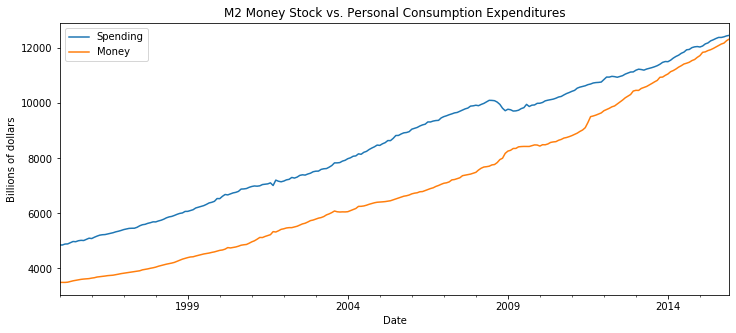

In [5]:
title = 'M2 Money Stock vs. Personal Consumption Expenditures'
ylabel='Billions of dollars'
xlabel=''

ax = df['Spending'].plot(figsize=(12,5),title=title,legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
df['Money'].plot(legend=True);

# Test for stationarity, perform any necessary transformations


In [6]:
# INCLUDED HERE IF YOU CHOOSE TO USE IT
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [44]:
adf_test(df['Money'],title='Money')

Augmented Dickey-Fuller Test: Money
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [45]:
adf_test(df['Spending'], title='Spending')

Augmented Dickey-Fuller Test: Spending
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [9]:
auto_arima(df['Money'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(3, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [10]:
auto_arima(df['Spending'],maxiter=1000)

ARIMA(maxiter=1000, method='lbfgs', order=(1, 1, 2), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [11]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [46]:
adf_test(df_transformed['Money'], title='MoneyFirstDiff')
print()
adf_test(df_transformed['Spending'], title='SpendingFirstDiff')

Augmented Dickey-Fuller Test: MoneyFirstDiff
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

Augmented Dickey-Fuller Test: SpendingFirstDiff
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [12]:
len(df_transformed)

250

# Train/test/split

In [14]:
nobs=12
train, test = df_transformed[0:-nobs], df_transformed[-nobs:]

In [15]:
print(train.shape)
print(test.shape)

(238, 2)
(12, 2)


# Fit the VARMA(1,2) Model

In [16]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.077
,+ intercept,AIC,4606.154
Date:,"Wed, 13 May 2020",BIC,4665.183
Time:,15:36:39,HQIC,4629.944
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.02, 29.13",Jarque-Bera (JB):,"527.45, 108.92"
Prob(Q):,"0.00, 0.90",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.44, 2.97",Skew:,"1.30, -0.32"


# Predict the next 12 values¶

In [17]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-10.303328,37.337527
2015-02-01,-10.748984,-3.742657
2015-03-01,0.201679,-0.352868
2015-04-01,-1.392663,-0.301678
2015-05-01,0.523283,0.173934
2015-06-01,-0.118787,0.078715
2015-07-01,0.294738,0.167530
2015-08-01,0.113382,0.134707
2015-09-01,0.211859,0.154536
2015-10-01,0.164586,0.145548


## Invert the Transformation
Remember that the forecasted values represent second-order differences. To compare them to the original data we have to roll back each difference. To roll back a first-order difference we take the most recent value on the training side of the original series, and add it to a cumulative sum of forecasted values. When working with second-order differences we first must perform this operation on the most recent first-order difference.

Here we'll use the <tt>nobs</tt> variable we defined during the train/test/split step.

In [19]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money'].cumsum()

In [22]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending'].cumsum()

In [23]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-10.303328,37.337527,68.296672,11659.796672,47.937527,12099.337527
2015-02-01,-10.748984,-3.742657,57.547689,11649.047689,44.194869,12095.594869
2015-03-01,0.201679,-0.352868,57.749368,11649.249368,43.842001,12095.242001
2015-04-01,-1.392663,-0.301678,56.356705,11647.856705,43.540322,12094.940322
2015-05-01,0.523283,0.173934,56.879988,11648.379988,43.714256,12095.114256
2015-06-01,-0.118787,0.078715,56.761201,11648.261201,43.792972,12095.192972
2015-07-01,0.294738,0.167530,57.055939,11648.555939,43.960502,12095.360502
2015-08-01,0.113382,0.134707,57.169321,11648.669321,44.095209,12095.495209
2015-09-01,0.211859,0.154536,57.381180,11648.881180,44.249746,12095.649746
2015-10-01,0.164586,0.145548,57.545766,11649.045766,44.395294,12095.795294


In [24]:
pd.concat([df.iloc[-12:],df_forecast[['MoneyForecast','SpendingForecast']]],axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11659.796672,12099.337527
2015-02-01,11852.4,12082.4,11649.047689,12095.594869
2015-03-01,11868.8,12158.3,11649.249368,12095.242001
2015-04-01,11916.1,12193.8,11647.856705,12094.940322
2015-05-01,11947.6,12268.1,11648.379988,12095.114256
2015-06-01,11993.1,12308.3,11648.261201,12095.192972
2015-07-01,12045.3,12355.4,11648.555939,12095.360502
2015-08-01,12096.8,12394.0,11648.669321,12095.495209
2015-09-01,12153.8,12392.8,11648.881180,12095.649746


# Plot the results

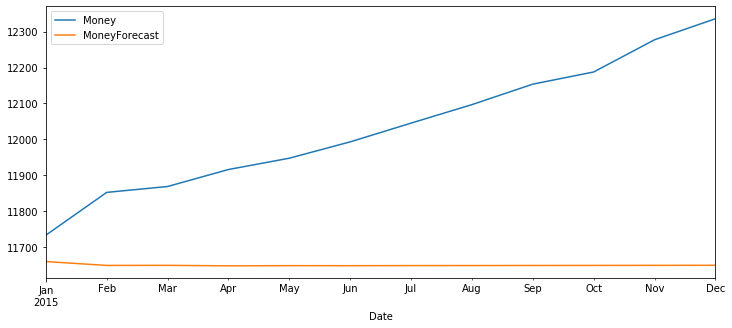

In [27]:
df['Money'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['MoneyForecast'].plot(legend=True);

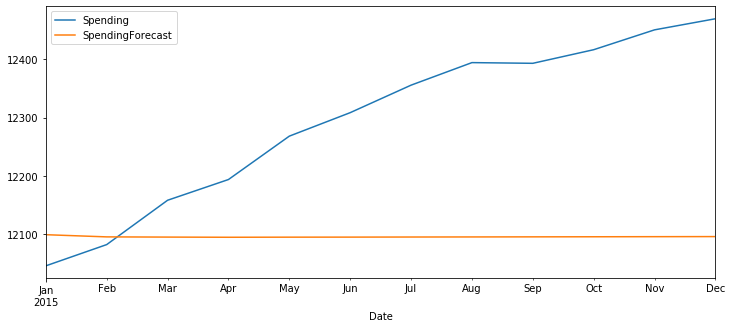

In [28]:
df['Spending'][-nobs:].plot(figsize=(12,5),legend=True).autoscale(axis='x',tight=True)
df_forecast['SpendingForecast'].plot(legend=True);

# Evaluate the model¶

In [29]:
RMSE1 = rmse(df['Money'][-nobs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 422.741


In [30]:
RMSE2 = rmse(df['Spending'][-nobs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 242.261


# Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!

Let's compare these results to individual ARMA(1,2) models

In [31]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [32]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Wed, 13 May 2020   AIC                           2245.421
Time:                        15:44:46   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.218      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.259     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8021           +0.0000j            2.8021            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [33]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [34]:
z1

,Money
2015-01-01,-14.498681
2015-02-01,-10.946725
2015-03-01,4.152675
2015-04-01,-1.235831
2015-05-01,0.687159
2015-06-01,0.000904
2015-07-01,0.245807
2015-08-01,0.158409
2015-09-01,0.189599
2015-10-01,0.178468


# Invert the Transformation, Evaluate the Forecast

In [35]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

In [36]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498681,64.101319,11734.201319
2015-02-01,-10.946725,53.154594,11787.355912
2015-03-01,4.152675,57.307268,11844.663181
2015-04-01,-1.235831,56.071438,11900.734619
2015-05-01,0.687159,56.758597,11957.493216
2015-06-01,0.000904,56.759501,12014.252717
2015-07-01,0.245807,57.005308,12071.258025
2015-08-01,0.158409,57.163717,12128.421742
2015-09-01,0.189599,57.353316,12185.775058
2015-10-01,0.178468,57.531784,12243.306841


In [37]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 422.741
Money  ARMA(1,2) RMSE: 32.238


# Personal Spending

In [38]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Wed, 13 May 2020   AIC                           2374.823
Time:                        15:47:04   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1440           +0.0000j            4.1440            0.5000
-----------------------------------------------------------------------------
"""

In [39]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555889
2015-02-01,-3.338287
2015-03-01,1.250676
2015-04-01,-0.310809
2015-05-01,0.220517
2015-06-01,0.039723
2015-07-01,0.101242
2015-08-01,0.080309
2015-09-01,0.087432
2015-10-01,0.085008


# Invert the Transformation, Evaluate the Forecas

In [40]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

In [41]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555889,44.155889,12106.155889
2015-02-01,-3.338287,40.817602,12146.973490
2015-03-01,1.250676,42.068278,12189.041768
2015-04-01,-0.310809,41.757469,12230.799236
2015-05-01,0.220517,41.977986,12272.777222
2015-06-01,0.039723,42.017708,12314.794931
2015-07-01,0.101242,42.118950,12356.913881
2015-08-01,0.080309,42.199259,12399.113139
2015-09-01,0.087432,42.286690,12441.399830
2015-10-01,0.085008,42.371698,12483.771528


In [42]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {RMSE2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 242.261
Spending  ARMA(1,2) RMSE: 52.334


CONCLUSION: It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.

